# Benchmarking Retrievers

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import spacy
import time
import torch
import wikipedia
from bs4 import BeautifulSoup
from math import log2
#from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util
from spacy.lang.en import stop_words
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer, AutoModel
from urllib.request import urlopen

from FlagEmbedding import FlagICLModel

/home/jovyan/.mlspace/envs/albert/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
def fix_random_seeds(seed):
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

fix_random_seeds(42)

In [3]:
sns.set_style('darkgrid')
sns.set(font_scale=1.4)
plt.rcParams['font.family'] = 'Serif'

In [4]:
filepaths_benchmark = []
filepaths_metrics = []
directory_benchmark = 'retrievers_benchmark'
directory_metrics = 'retrievers_metrics'

for filename in os.listdir(directory_benchmark):
    f_benchmark = os.path.join(directory_benchmark, filename)
    f_metrics = os.path.join(directory_metrics, filename)
    filepaths_benchmark.append(f_benchmark)
    filepaths_metrics.append(f_metrics)

filepaths_benchmark = sorted(filepaths_benchmark)
filepaths_metrics = sorted(filepaths_metrics)

In [5]:
mapping = {
    0.0: 0,
    1.0: 1,
    2.1: 2,
    2.2: 3,
    2.3: 4,
    3.0: 5
}

mapping_binary = {
    0.0: 0,
    1.0: 0,
    2.1: 0,
    2.2: 0,
    2.3: 1,
    3.0: 1
}

for filepath in filepaths_benchmark:
    df = pd.read_csv(filepath)
    df['Relevance Score'] = df['Annotation'].map(mapping)
    df['Binary Relevance Score'] = df['Annotation'].map(mapping_binary)
    df['BM25 Rank'] = df.index + 1
    df.to_csv(filepath, index=False)

## Metric: Normalized Discounted Cumulative Gain (NDCG@K)

In [6]:
def ndcg(relevance_scores):
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)

    dcg = 0
    idcg = 0
    ndcg = []

    for k in range(1, len(relevance_scores) + 1):
        rel_k = relevance_scores[k-1]
        ideal_rel_k = ideal_relevance_scores[k-1]
        dcg += rel_k / log2(k + 1)
        idcg += ideal_rel_k / log2(k + 1)
        ndcg.append(dcg / idcg)

    return ndcg

## The Only Language-Agnostic Ranker (aka Baseline): BM25

In [7]:
'''
for i, f_benchmark in enumerate(filepaths_benchmark):
    df_benchmark = pd.read_csv(f_benchmark)
    df_metrics = pd.DataFrame(
        {
            'BM25 Paragraphs': df_benchmark['Paragraph'], 
            'BM25 Relevance Score': df_benchmark['Relevance Score'],
            'BM25 NDCG@K': ndcg(df_benchmark['Relevance Score']),
        }
    )
    df_metrics.to_csv(filepaths_metrics[i], index=False)
'''

"\nfor i, f_benchmark in enumerate(filepaths_benchmark):\n    df_benchmark = pd.read_csv(f_benchmark)\n    df_metrics = pd.DataFrame(\n        {\n            'BM25 Paragraphs': df_benchmark['Paragraph'], \n            'BM25 Relevance Score': df_benchmark['Relevance Score'],\n            'BM25 NDCG@K': ndcg(df_benchmark['Relevance Score']),\n        }\n    )\n    df_metrics.to_csv(filepaths_metrics[i], index=False)\n"

## Wikipedia Summary as Query

In [8]:
def get_query(term, language):
    soup = BeautifulSoup(urlopen('http://en.wikipedia.org/wiki/' + (term[:1].upper() + term[1:]).replace(' ', '_')), features="lxml")
    interwikihead = soup.find('li', class_=('interlanguage-link interwiki-' + language + ' mw-list-item'))

    try:
        if language == 'en':
            title = term[:1].upper() + term[1:]
        else:
            title = interwikihead.a.get('title').split(u' – ')[0]
        wikipedia.set_lang(language)
        page = wikipedia.page(title, auto_suggest=False)
        return page.summary
    except:
        return None

In [9]:
query = get_query('Word order', 'en')
query

'In linguistics, word order (also known as linear order) is the order of the syntactic constituents of a language. Word order typology studies it from a cross-linguistic perspective, and examines how languages employ different orders. Correlations between orders found in different syntactic sub-domains are also of interest. The primary word orders that are of interest are\n\nthe constituent order of a clause, namely the relative order of subject, object, and verb;\nthe order of modifiers (adjectives, numerals, demonstratives, possessives, and adjuncts) in a noun phrase;\nthe order of adverbials.\nSome languages use relatively fixed word order, often relying on the order of constituents to convey grammatical information. Other languages—often those that convey grammatical information through inflection—allow more flexible word order, which can be used to encode pragmatic information, such as topicalisation or focus. However, even languages with flexible word order have a preferred or ba

In [10]:
term_only_query = 'Dominant word order (Order of Subject, Object, and Verb)'

## Embeddings

https://huggingface.co/spaces/mteb/leaderboard

Retrieval English Leaderboard 🔎

Metric: Normalized Discounted Cumulative Gain @ k (ndcg_at_10)

## Functions for Retrievers

In [10]:
def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

def get_scores_on_batch(query_embedding, documents, model):
    with torch.no_grad():
        documents_embeddings = model.encode(documents)
        scores = util.cos_sim(query_embedding, documents_embeddings) * 100
        return scores.tolist()[0]

In [11]:
def rerank_and_save(model_name, cos_sim_scores, df, df_output_filepath):
    order = sorted(range(len(cos_sim_scores)), key=lambda i: cos_sim_scores[i], reverse=True)
    reranked_cos_sim_scores = [cos_sim_scores[i] for i in order]
    reranked_relevance_scores = [df['Relevance Score'][i] for i in order]
    reranked_paragraphs = [df['Paragraph'][i] for i in order]
    ndcg_scores = ndcg(reranked_relevance_scores)
    df_metrics = pd.read_csv(df_output_filepath)
    df_metrics[f'{model_name} Paragraphs'] = reranked_paragraphs
    df_metrics[f'{model_name} Cosine Similarity'] = reranked_cos_sim_scores
    df_metrics[f'{model_name} Relevance Score'] = reranked_relevance_scores
    df_metrics[f'{model_name} NDCG@K'] = ndcg_scores
    df_metrics.to_csv(df_output_filepath, index=False)

In [12]:
default_instruct = 'Given a web search query, retrieve relevant passages that answer the query'
specific_instruct = 'Given a definition of a linguistic feature, retrieve relevant passages that let a linguist unambiguously determine the value of this feature in the described language'

In [13]:
def get_record_name(query, model_name, instruct):
    if instruct == default_instruct:
        record_name = model_name + ' Default Instruct'
    elif instruct == specific_instruct:
        record_name = model_name + ' Specific Instruct'
    if query == term_only_query:
        record_name += ': Term Only'
    return record_name

In [14]:
def get_ndcg_on_dataset(query, model, model_name, instruct=None):
    record_name = get_record_name(query, model_name, instruct)
    if instruct != None:
        if 'stella_en_1.5B_v5' in model_name:
            instruct += '.'
        query = get_detailed_instruct(instruct, query)
    with torch.no_grad():
        query_embedding = model.encode([query])
    for i, f_benchmark in enumerate(filepaths_benchmark):
        df = pd.read_csv(f_benchmark)
        cos_sim_scores = []
        for k in tqdm(range(0, 50), desc=f'Processing file {i + 1}', ncols=100):
            cos_sim_scores.extend(get_scores_on_batch(query_embedding, [df['Paragraph'][k]], model))
        rerank_and_save(record_name, cos_sim_scores, df, filepaths_metrics[i])

### MTEB #1: bge-en-icl

In [15]:
def get_ndcg_on_dataset_icl(query, model_name, instruct):
    record_name = get_record_name(query, model_name, instruct)
    instruct += '.'
    model = FlagICLModel(
        f'BAAI/{model_name}', 
        query_instruction_for_retrieval=instruct,
        examples_for_task=None,
        use_fp16=False,
    )
    with torch.no_grad():
        query_embedding = model.encode_queries([query])
    for i, f_benchmark in enumerate(filepaths_benchmark):
        df = pd.read_csv(f_benchmark)
        cos_sim_scores = []
        for k in tqdm(range(0, 50), desc=f'Processing file {i + 1}', ncols=100):
            with torch.no_grad():
                document_embedding = model.encode_corpus([df['Paragraph'][k]])
            cos_sim_scores.extend((util.cos_sim(query_embedding, document_embedding) * 100).tolist()[0])
        rerank_and_save(record_name, cos_sim_scores, df, filepaths_metrics[i])

In [16]:
# bge-en-icl Default Instruct: Term Only
get_ndcg_on_dataset_icl(term_only_query, 'bge-en-icl', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.69it/s]


In [17]:
# bge-en-icl Specific Instruct: Term Only
get_ndcg_on_dataset_icl(term_only_query, 'bge-en-icl', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.70it/s]


In [18]:
# bge-en-icl Default Instruct
get_ndcg_on_dataset_icl(query, 'bge-en-icl', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.70it/s]


In [19]:
# bge-en-icl Specific Instruct
get_ndcg_on_dataset_icl(query, 'bge-en-icl', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.70it/s]


### MTEB #2: stella_en_1.5B_v5

In [15]:
model = SentenceTransformer('dunzhang/stella_en_1.5B_v5', trust_remote_code=True)

In [16]:
# stella_en_1.5B_v5 Default Instruct: Term Only
get_ndcg_on_dataset(term_only_query, model, 'stella_en_1.5B_v5', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 16.90it/s]


In [17]:
# stella_en_1.5B_v5 Specific Instruct: Term Only
get_ndcg_on_dataset(term_only_query, model, 'stella_en_1.5B_v5', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 17.59it/s]


In [18]:
# stella_en_1.5B_v5 Default Instruct
get_ndcg_on_dataset(query, model, 'stella_en_1.5B_v5', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 16.70it/s]


In [19]:
# stella_en_1.5B_v5 Specific Instruct
get_ndcg_on_dataset(query, model, 'stella_en_1.5B_v5', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 16.71it/s]


### MTEB #3: NV-Retriever-v1

In [16]:
tokenizer = AutoTokenizer.from_pretrained('nvidia/NV-Retriever-v1')
model = AutoModel.from_pretrained('nvidia/NV-Retriever-v1', trust_remote_code=True).cuda()
tokenizer_kwargs = {        
    'padding': True, 
    'truncation': True, 
    'return_tensors': 'pt',
}

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.24s/it]


In [17]:
def get_ndcg_on_dataset_nv_retriever(query, model, model_name, instruct):
    record_name = get_record_name(query, model_name, instruct)
    instruct += ': '
    document_prefix = 'passage: '
    tokenized_query = tokenizer([instruct + query], **tokenizer_kwargs)
    with torch.no_grad():
        query_embedding = model(**tokenized_query.to(device='cuda'))
    for i, f_benchmark in enumerate(filepaths_benchmark):
        df = pd.read_csv(f_benchmark)
        cos_sim_scores = []
        for k in tqdm(range(0, 50), desc=f'Processing file {i + 1}', ncols=100):
            document = document_prefix + df['Paragraph'][k]
            tokenized_document = tokenizer([document], **tokenizer_kwargs)
            with torch.no_grad():
                document_embedding = model(**tokenized_document.to(device='cuda'))
            cos_sim_scores.extend((util.cos_sim(query_embedding, document_embedding) * 100).tolist()[0])
        rerank_and_save(record_name, cos_sim_scores, df, filepaths_metrics[i])

In [18]:
# NV-Retriever-v1 Default Instruct: Term Only
get_ndcg_on_dataset_nv_retriever(term_only_query, model, 'NV-Retriever-v1', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.74it/s]


In [19]:
# NV-Retriever-v1 Specific Instruct: Term Only
get_ndcg_on_dataset_nv_retriever(term_only_query, model, 'NV-Retriever-v1', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


In [20]:
# NV-Retriever-v1 Default Instruct
get_ndcg_on_dataset_nv_retriever(query, model, 'NV-Retriever-v1', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


In [21]:
# NV-Retriever-v1 Specific Instruct
get_ndcg_on_dataset_nv_retriever(query, model, 'NV-Retriever-v1', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


### MTEB #4: gte-Qwen2-7B-instruct

In [15]:
model = SentenceTransformer('Alibaba-NLP/gte-Qwen2-7B-instruct', trust_remote_code=True)

Loading checkpoint shards: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


In [16]:
# gte-Qwen2-7B-instruct Default Instruct: Term Only
get_ndcg_on_dataset(term_only_query, model, 'gte-Qwen2-7B-instruct', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.72it/s]


In [17]:
# gte-Qwen2-7B-instruct Specific Instruct: Term Only
get_ndcg_on_dataset(term_only_query, model, 'gte-Qwen2-7B-instruct', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.72it/s]


In [18]:
# gte-Qwen2-7B-instruct Default Instruct
get_ndcg_on_dataset(query, model, 'gte-Qwen2-7B-instruct', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.73it/s]


In [19]:
# gte-Qwen2-7B-instruct Specific Instruct
get_ndcg_on_dataset(query, model, 'gte-Qwen2-7B-instruct', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.73it/s]


### MTEB #5: Linq-Embed-Mistral

In [15]:
model = SentenceTransformer('Linq-AI-Research/Linq-Embed-Mistral')

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it]


In [16]:
# Linq-Embed-Mistral Default Instruct: Term Only
get_ndcg_on_dataset(term_only_query, model, 'Linq-Embed-Mistral', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


In [17]:
# Linq-Embed-Mistral Specific Instruct: Term Only
get_ndcg_on_dataset(term_only_query, model, 'Linq-Embed-Mistral', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


In [18]:
# Linq-Embed-Mistral Default Instruct
get_ndcg_on_dataset(query, model, 'Linq-Embed-Mistral', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.24it/s]


In [19]:
# Linq-Embed-Mistral Specific Instruct
get_ndcg_on_dataset(query, model, 'Linq-Embed-Mistral', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.25it/s]


### MTEB #6: SFR-Embedding-2_R

In [15]:
model = SentenceTransformer('Salesforce/SFR-Embedding-2_R')

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


In [16]:
# SFR-Embedding-2_R Default Instruct: Term Only
get_ndcg_on_dataset(term_only_query, model, 'SFR-Embedding-2_R', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


In [17]:
# SFR-Embedding-2_R Specific Instruct: Term Only
get_ndcg_on_dataset(term_only_query, model, 'SFR-Embedding-2_R', specific_instruct)

Processing file 1:   4%|█▊                                           | 2/50 [00:00<00:12,  3.90it/s]

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


In [18]:
# SFR-Embedding-2_R Default Instruct
get_ndcg_on_dataset(query, model, 'SFR-Embedding-2_R', default_instruct)

Processing file 1:   2%|▉                                            | 1/50 [00:00<00:12,  3.85it/s]

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


In [19]:
# SFR-Embedding-2_R Specific Instruct
get_ndcg_on_dataset(query, model, 'SFR-Embedding-2_R', specific_instruct)

Processing file 1:   2%|▉                                            | 1/50 [00:00<00:12,  3.89it/s]

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


### MTEB #7: NV-Embed-v1

In [15]:
model = AutoModel.from_pretrained('nvidia/NV-Embed-v2', trust_remote_code=True).cuda()

Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


In [ ]:
# NV-Embed-v1 Default Instruct: Term Only
get_ndcg_on_dataset(term_only_query, model, 'NV-Embed-v2', default_instruct)

In [ ]:
import torch
from sentence_transformers import SentenceTransformer

# load model with tokenizer
model = SentenceTransformer('nvidia/NV-Embed-v2', trust_remote_code=True)
model.max_seq_length = 4096
model.tokenizer.padding_side="right"

In [ ]:

# Each query needs to be accompanied by an corresponding instruction describing the task.
task_name_to_instruct = {"example": "Given a question, retrieve passages that answer the question",}

query_prefix = "Instruct: "+task_name_to_instruct["example"]+"\nQuery: "
queries = [
    'are judo throws allowed in wrestling?', 
    'how to become a radiology technician in michigan?'
    ]

# No instruction needed for retrieval passages
passages = [
    "Since you're reading this, you are probably someone from a judo background or someone who is just wondering how judo techniques can be applied under wrestling rules. So without further ado, let's get to the question. Are Judo throws allowed in wrestling? Yes, judo throws are allowed in freestyle and folkstyle wrestling. You only need to be careful to follow the slam rules when executing judo throws. In wrestling, a slam is lifting and returning an opponent to the mat with unnecessary force.",
    "Below are the basic steps to becoming a radiologic technologist in Michigan:Earn a high school diploma. As with most careers in health care, a high school education is the first step to finding entry-level employment. Taking classes in math and science, such as anatomy, biology, chemistry, physiology, and physics, can help prepare students for their college studies and future careers.Earn an associate degree. Entry-level radiologic positions typically require at least an Associate of Applied Science. Before enrolling in one of these degree programs, students should make sure it has been properly accredited by the Joint Review Committee on Education in Radiologic Technology (JRCERT).Get licensed or certified in the state of Michigan."
]

def add_eos(input_examples):
  input_examples = [input_example + model.tokenizer.eos_token for input_example in input_examples]
  return input_examples

# get the embeddings
batch_size = 1
query_embeddings = model.encode(add_eos(queries), batch_size=batch_size, prompt=query_prefix, normalize_embeddings=True)
passage_embeddings = model.encode(add_eos(passages), batch_size=batch_size, normalize_embeddings=True)

scores = (query_embeddings @ passage_embeddings.T) * 100
print(scores.tolist())

### Baseline: BM25

In [55]:
stopwords = stop_words.STOP_WORDS
model = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
model.max_length = 5000000

In [56]:
def get_lemmatized_query(query):
    tokenized_query = model(query.lower())
    lemmatized_query = []

    for token in tokenized_query:
        if token.lemma_ not in stopwords and token.is_alpha:
            lemmatized_query.append(token.lemma_)

    return lemmatized_query

In [57]:
lemmatized_term_only_query = get_lemmatized_query(term_only_query)
lemmatized_query = get_lemmatized_query(query)

In [58]:
def get_scores_bm25(lemmatized_query, paragraphs):
    lemmatized_paragraphs = []

    for paragraph in paragraphs:
        lemmatized_paragraph = []
        doc = model(paragraph.lower())
        for token in doc:
            if token.lemma_ not in stopwords and token.is_alpha:
                lemmatized_paragraph.append(token.lemma_)
        lemmatized_paragraphs.append(lemmatized_paragraph)
    bm25 = BM25Okapi(lemmatized_paragraphs)

    return bm25.get_scores(lemmatized_query)

In [60]:
for i, f_benchmark in enumerate(filepaths_benchmark):
    df = pd.read_csv(f_benchmark)
    bm25_scores_term_only = get_scores_bm25(lemmatized_term_only_query, list(df['Paragraph']))
    rerank_and_save('BM25: Term Only', bm25_scores_term_only, df, filepaths_metrics[i])
    bm25_scores = get_scores_bm25(lemmatized_query, list(df['Paragraph']))
    rerank_and_save('BM25', bm25_scores, df, filepaths_metrics[i])

### Plots

In [38]:
filepaths_benchmark = []
filepaths_metrics = []
filepaths_metrics_old = []
directory_benchmark = 'retrievers_benchmark'
directory_metrics = 'retrievers_metrics'
directory_metrics_old = 'retrievers_metrics_old'

for filename in os.listdir(directory_benchmark):
    f_benchmark = os.path.join(directory_benchmark, filename)
    f_metrics = os.path.join(directory_metrics, filename)
    f_metrics_old = os.path.join(directory_metrics_old, filename)
    filepaths_benchmark.append(f_benchmark)
    filepaths_metrics.append(f_metrics)
    filepaths_metrics_old.append(f_metrics_old)

filepaths_metrics = sorted(filepaths_metrics)
filepaths_metrics_old = sorted(filepaths_metrics_old)

In [45]:
plt.rcParams['legend.title_fontsize'] = 'xx-small'

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [46]:
best_metrics = ['BM25', 'bge-en-icl Default Instruct: Term Only', 'stella_en_1.5B_v5 Default Instruct', 'NV-Retriever-v1 Default Instruct', 'gte-Qwen2-7B-instruct Specific Instruct: Term Only', 'Linq-Embed-Mistral Specific Instruct: Term Only', 'SFR-Embedding-2_R Specific Instruct: Term Only']

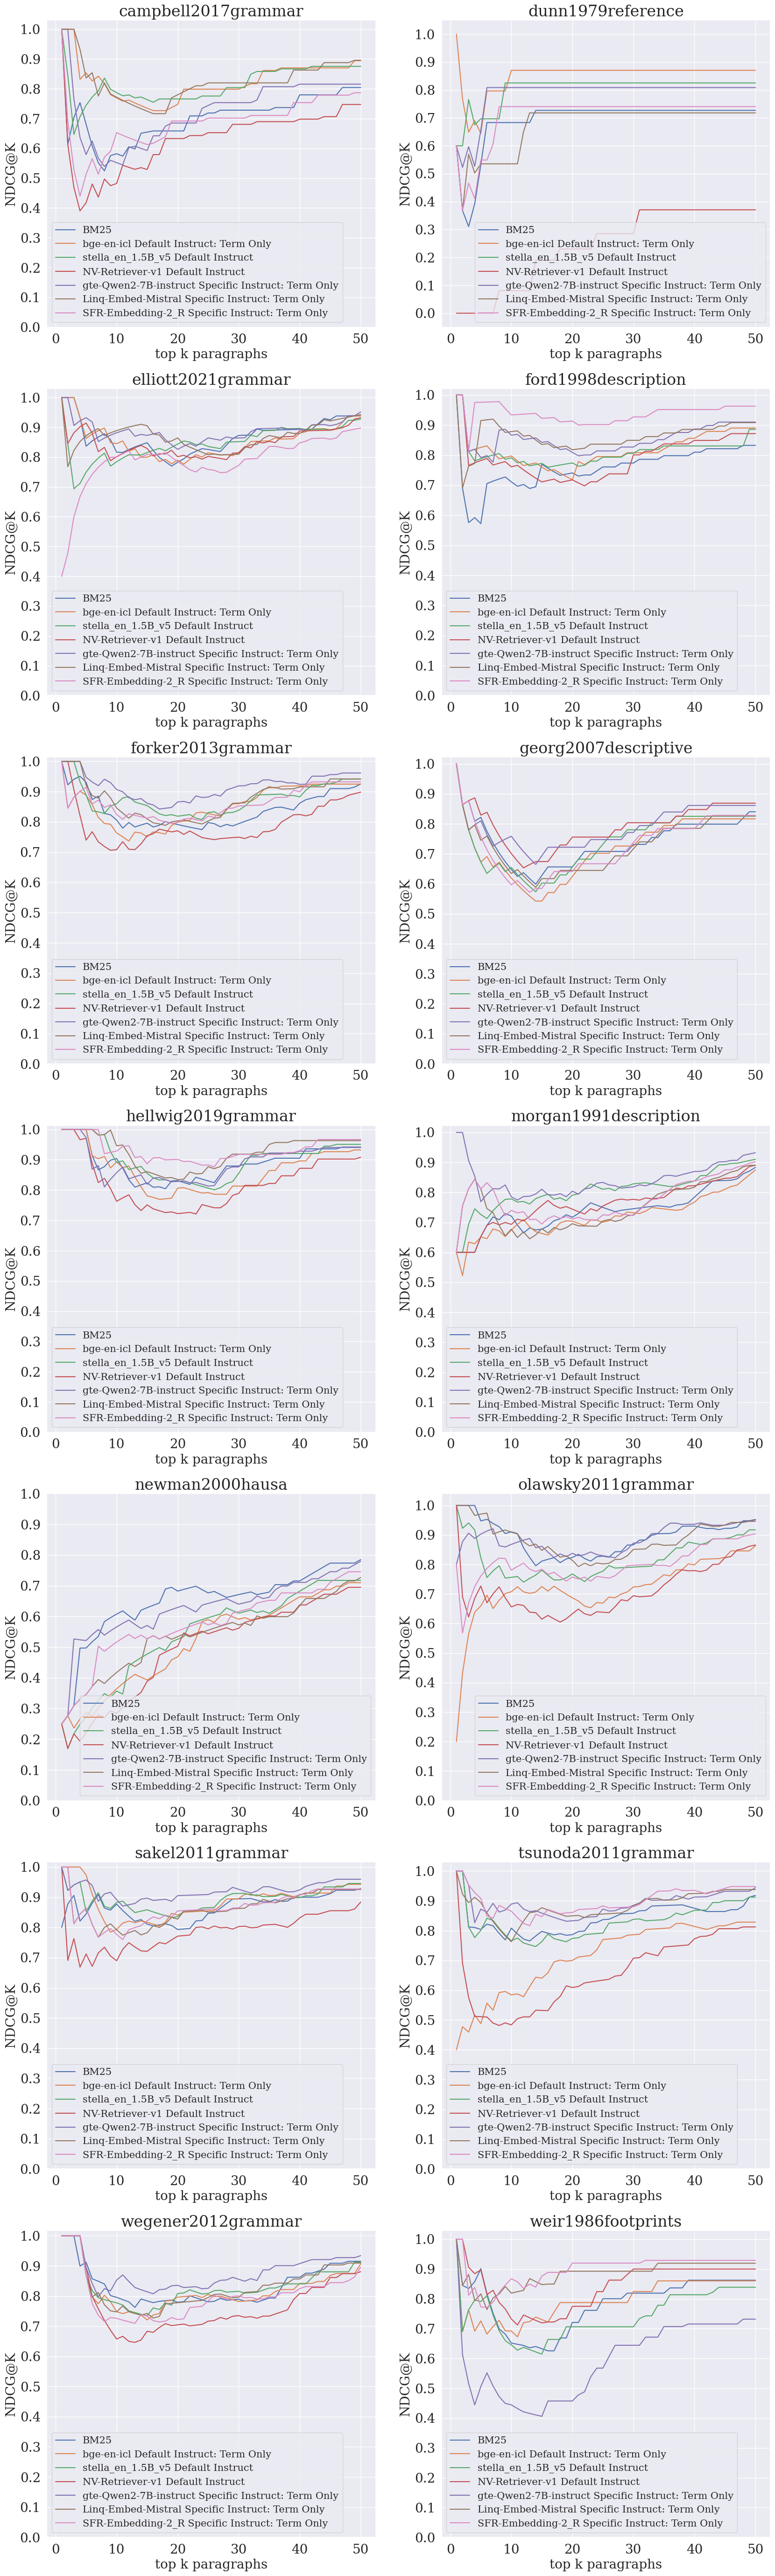

In [47]:
x = range(1, 51)
plt.rcParams['figure.figsize'] = (20, 70)
fig, axs = plt.subplots(7, 2)
for i in range(7):
    for j in range(2):
        df = pd.read_csv(filepaths_metrics[i * 2 + j])
        for model in best_metrics:
            column = model + ' NDCG@K'
            axs[i, j].set_title(os.path.basename(filepaths_metrics[i * 2 + j][:-4]))
            axs[i, j].plot(x, df[column], label=column[:-7])
            axs[i, j].set_yticks([index / 10.0 for index in range(0, 11)])
            axs[i, j].set_xlabel('top k paragraphs')
            axs[i, j].set_ylabel('NDCG@K')
            axs[i, j].legend()
plt.savefig('ndcg.png')

In [48]:
mean_ndcg_scores = {}
for i in range(14):
    df = pd.read_csv(filepaths_metrics_old[i])
    for column in df.columns:
        if 'NDCG@K' in column:
            if column[:-7] not in mean_ndcg_scores:
                mean_ndcg_scores[column[:-7]] = [0] * 50
            for k in range(50):
                mean_ndcg_scores[column[:-7]][k] += df[column][k]

for key in mean_ndcg_scores:
    for k in range(50):
        mean_ndcg_scores[key][k] /= 14

### NDCG@20

In [49]:
for key in mean_ndcg_scores:
    print(f'{key}: {mean_ndcg_scores[key][19]}')

BM25: 0.7493542061563343
SFR-Embedding-Mistral Default Instruct: 0.7526507981332495
SFR-Embedding-Mistral Specific Instruct: 0.7776379258691596
gte-large-en-v1.5: 0.610042434776429
GritLM-7B Default Instruct: 0.7442991752587949
GritLM-7B Specific Instruct: 0.7397611197557533
e5-mistral-7b-instruct Default Instruct: 0.751416940153738
e5-mistral-7b-instruct Specific Instruct: 0.7745951895584156
voyage-large-2-instruct: 0.7346896411634362
SFR-Embedding-Mistral Default Instruct: Term Only: 0.7380780346386723
SFR-Embedding-Mistral Specific Instruct: Term Only: 0.7624634946102573
gte-large-en-v1.5: Term Only: 0.6815884346788073
GritLM-7B Default Instruct: Term Only: 0.7301620756199892
GritLM-7B Specific Instruct: Term Only: 0.7343231782690537
e5-mistral-7b-instruct Default Instruct: Term Only: 0.7330779241127344
e5-mistral-7b-instruct Specific Instruct: Term Only: 0.7497664455802653
voyage-large-2-instruct: Term Only: 0.721739746178932


1:
Linq-Embed-Mistral Specific Instruct: Term Only: 0.7752980031663828

2:
SFR-Embedding-2_R Specific Instruct: Term Only: 0.7749772522185691

3:
gte-Qwen2-7B-instruct Specific Instruct: Term Only: 0.7748479642306731

4:
stella_en_1.5B_v5 Default Instruct: 0.7658818466045759

5:
BM25: 0.7493542061563343

6:
bge-en-icl Default Instruct: Term Only: 0.7386598677184361

7:
NV-Retriever-v1 Default Instruct: 0.669278277616485

### NDCG@50

In [26]:
for key in mean_ndcg_scores:
    print(f'{key}: {mean_ndcg_scores[key][49]}')

BM25: 0.8756355883164632
bge-en-icl Default Instruct: Term Only: 0.8752168358335263
bge-en-icl Specific Instruct: Term Only: 0.8374189288185684
bge-en-icl Default Instruct: 0.8481538961861324
bge-en-icl Specific Instruct: 0.8522421198209322
stella_en_1.5B_v5 Default Instruct: Term Only: 0.8777247794574479
stella_en_1.5B_v5 Specific Instruct: Term Only: 0.8715761606888657
stella_en_1.5B_v5 Default Instruct: 0.8847346626645045
stella_en_1.5B_v5 Specific Instruct: 0.876777079491756
NV-Retriever-v1 Default Instruct: Term Only: 0.8007299154758262
NV-Retriever-v1 Specific Instruct: Term Only: 0.8185275673307313
NV-Retriever-v1 Default Instruct: 0.8232465875886416
NV-Retriever-v1 Specific Instruct: 0.8159588641692218
gte-Qwen2-7B-instruct Default Instruct: Term Only: 0.8795885500841994
gte-Qwen2-7B-instruct Specific Instruct: Term Only: 0.8911753225359176
gte-Qwen2-7B-instruct Default Instruct: 0.8634020919376704
gte-Qwen2-7B-instruct Specific Instruct: 0.871540443647051
Linq-Embed-Mistral De

In [27]:
retriever_names = list(mean_ndcg_scores.keys())
retriever_names = [item for item in retriever_names if 'Term Only' not in item and 'BM25' not in item]

In [28]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

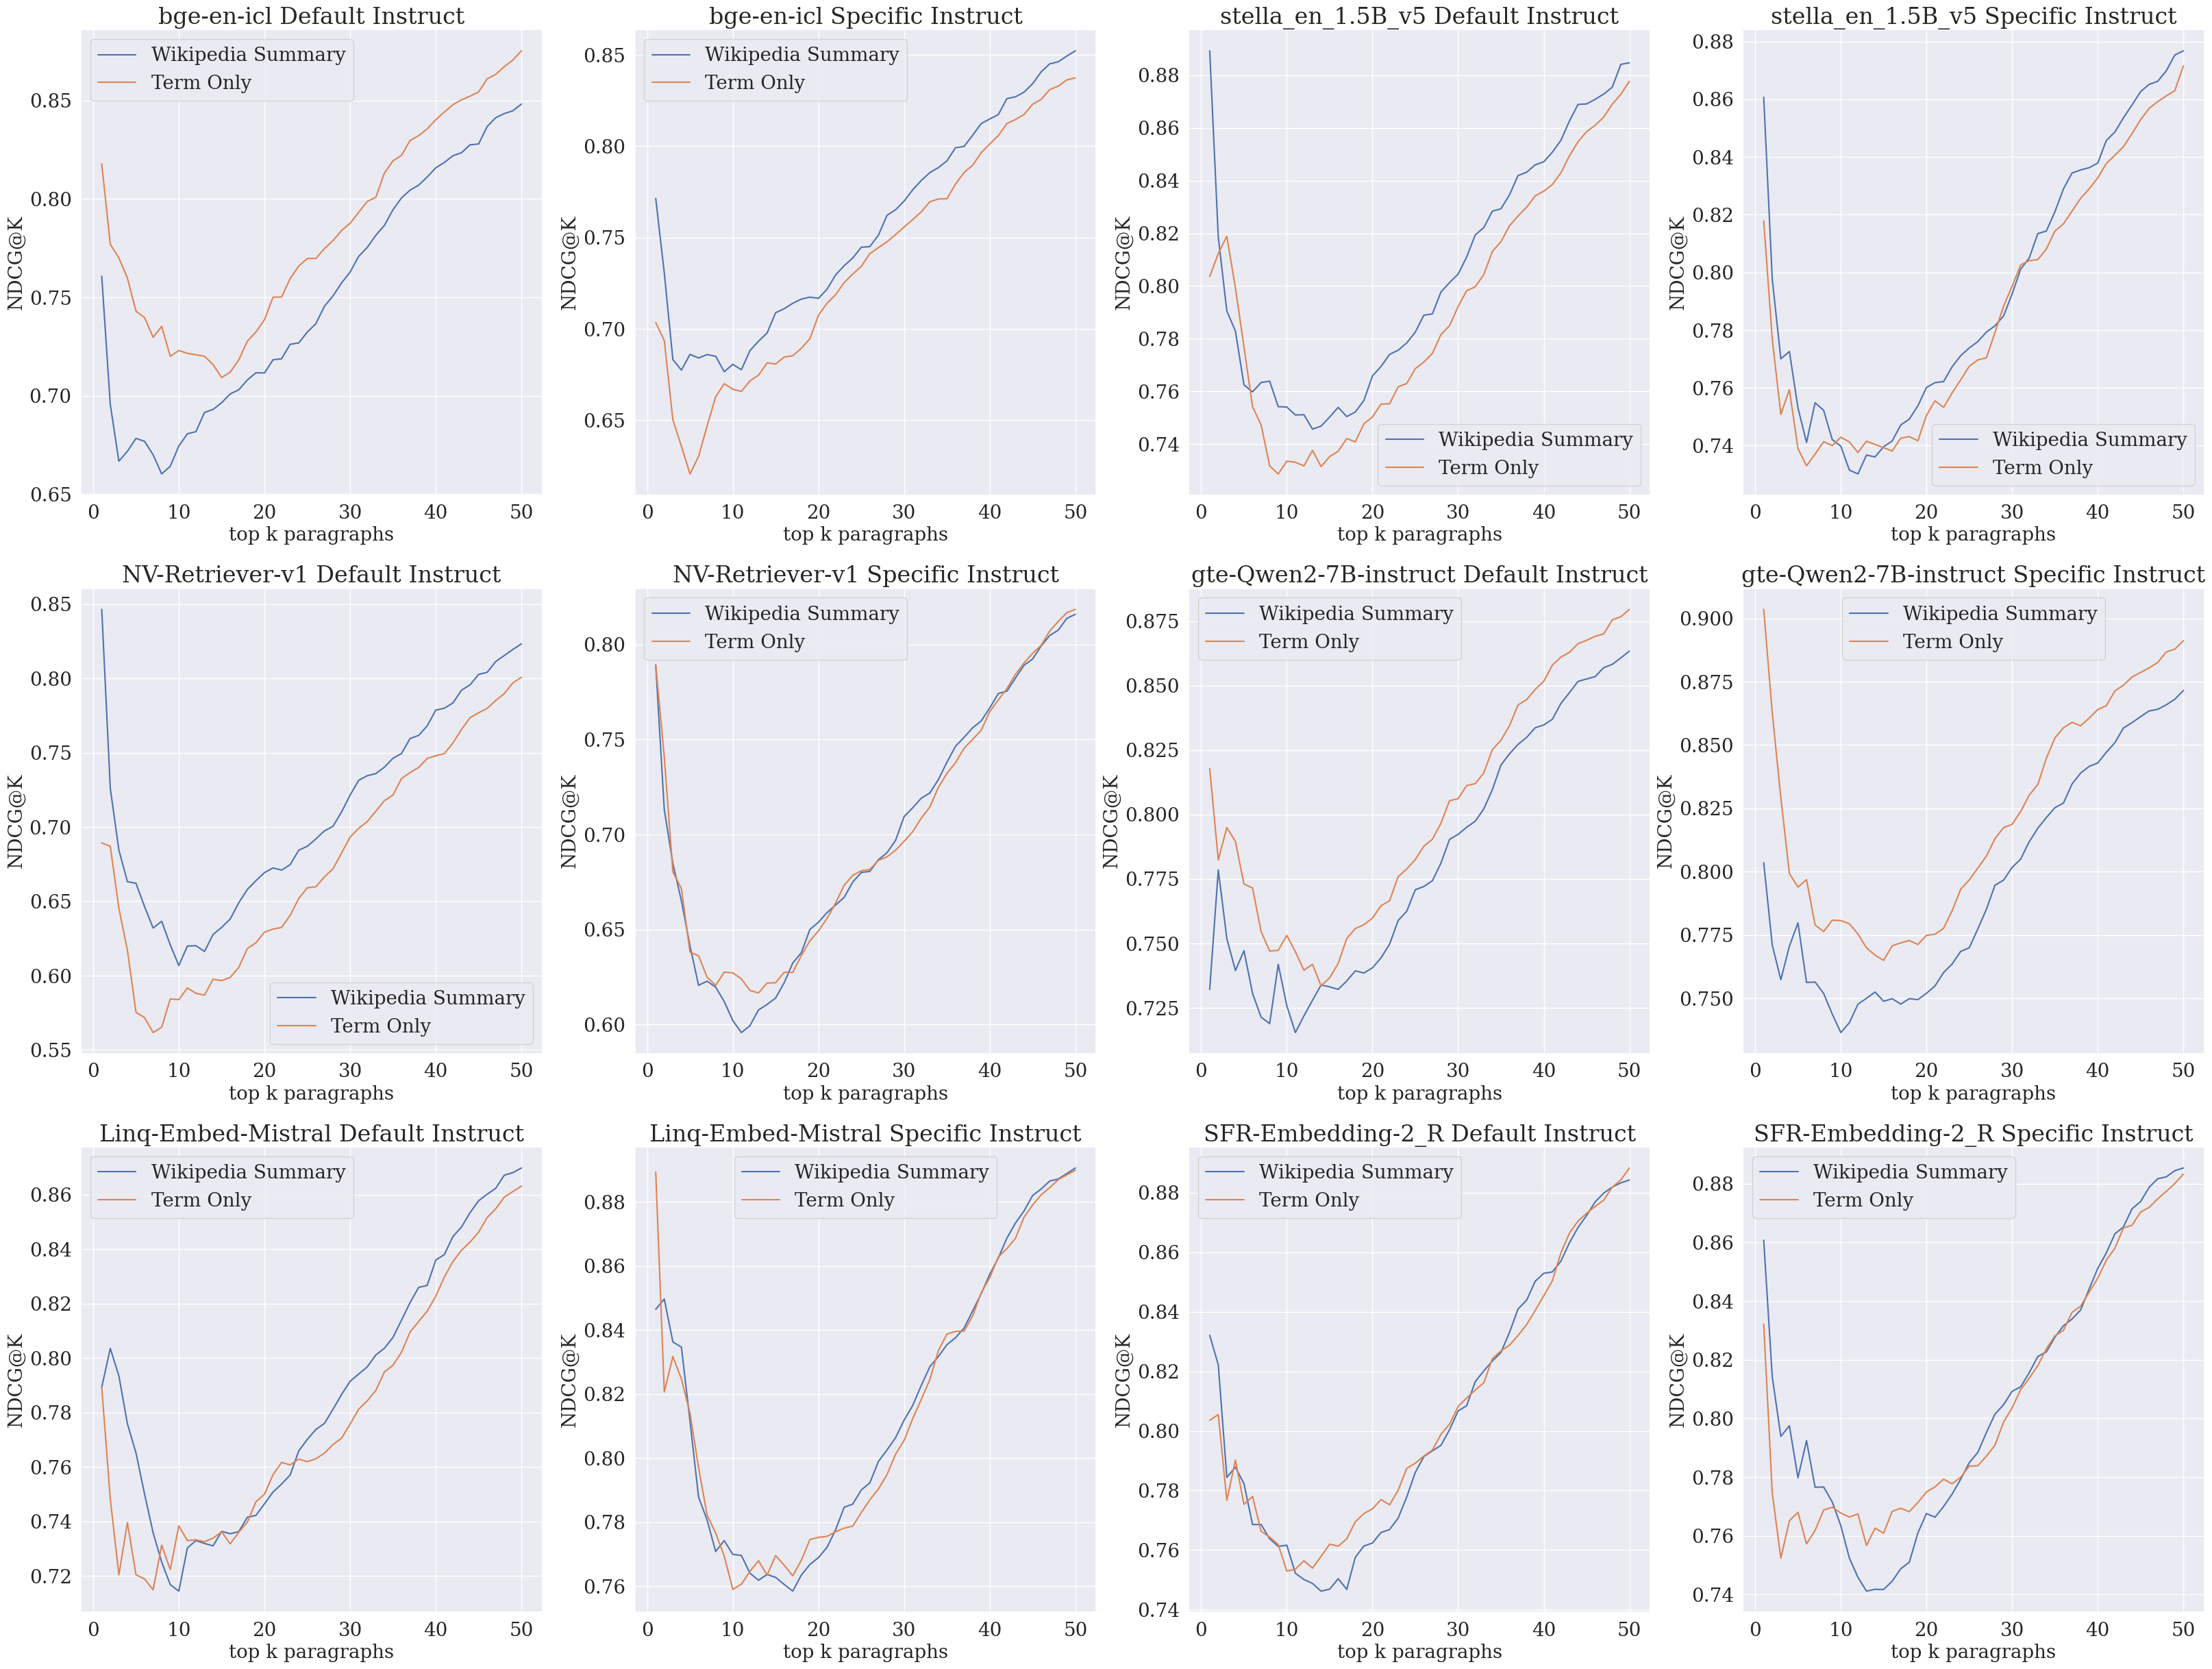

In [34]:
x = range(1, 51)
plt.rcParams['figure.figsize'] = (40, 30)
fig, axs = plt.subplots(3, 4)
for i in range(3):
    for j in range(4):
        keys = []
        title = retriever_names[i * 4 + j]
        keys = [title, title + ': Term Only']
        axs[i, j].set_title(title)
        axs[i, j].plot(x, mean_ndcg_scores[keys[0]], label='Wikipedia Summary')
        axs[i, j].plot(x, mean_ndcg_scores[keys[1]], label='Term Only')
        #axs[i, j].set_yticks([index / 10.0 for index in range(0, 11)])
        axs[i, j].set_xlabel('top k paragraphs')
        axs[i, j].set_ylabel('NDCG@K')
        axs[i, j].legend()
plt.savefig('term_only_comparison.png')

### Winner Reranker Inference

In [ ]:
model = SentenceTransformer('Salesforce/SFR-Embedding-Mistral')
model.eval();

In [63]:
def save_inference(query, model, path_to_paragraphs, df_output_filepath, instruct=None):
    if instruct == None:
        query_embedding = model.encode([query])
    else:
        query_embedding = model.encode([get_detailed_instruct(instruct, query)])
    for i, f_benchmark in enumerate(filenames_for_benchmark):
        df_output = pd.read_csv(df_output_filepath)
        if f_benchmark not in df_output.columns:
            df = pd.read_csv(f'{path_to_paragraphs}{f_benchmark}.csv')
            cos_sim_scores = []
            for k in tqdm(
                range(0, min(len(df['Paragraph']), 50)),
                desc=f'Processing file {i + 1}',
                ncols=100
            ):
                cos_sim_scores.extend(get_scores_on_batch(query_embedding, [df['Paragraph'][k]], model))
            if len(df['Paragraph']) < 50:
                cos_sim_scores.extend([0] * (50 - len(df['Paragraph'])))
            df_output[f_benchmark] = cos_sim_scores
            df_output.to_csv(df_output_filepath, index=False)

In [49]:
df_with_filenames = pd.read_csv('annotated_benchmark.csv')
filenames_for_benchmark = df_with_filenames['Filename']

In [54]:
save_inference(
    query, 
    model, 
    path_to_paragraphs='Grammars Paragraphs/WALS 81A/Wikipedia 50/', 
    df_output_filepath='Mistral Similarity Scores/WALS 81A/scores.csv', 
    instruct=specific_instruct
)

Processing file 148: 100%|██████████████████████████████████████████| 50/50 [00:43<00:00,  1.16it/s]


In [64]:
save_inference(
    query, 
    model, 
    path_to_paragraphs='Grammars Paragraphs/WALS 81A/Wikipedia 50 with layout/', 
    df_output_filepath='Mistral Similarity Scores/WALS 81A/scores_with_layout.csv', 
    instruct=specific_instruct
)

Processing file 148: 100%|██████████████████████████████████████████| 50/50 [00:30<00:00,  1.66it/s]


In [65]:
empty_df = pd.DataFrame(columns = ['Paragraph Number'], 
             index=range(0, 50))
empty_df.to_csv('Mistral Similarity Scores/GB 107/scores.csv', index=False)
empty_df.to_csv('Mistral Similarity Scores/GB 107/scores_with_layout.csv', index=False)

In [68]:
save_inference(
    query=get_query('Affirmation and negation', 'en'), 
    model=model,
    path_to_paragraphs='Grammars Paragraphs/GB 107/Wikipedia 50/', 
    df_output_filepath='Mistral Similarity Scores/GB 107/scores.csv', 
    instruct=specific_instruct
)

Processing file 148: 100%|██████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


In [71]:
save_inference(
    query=get_query('Affirmation and negation', 'en'), 
    model=model, 
    path_to_paragraphs='Grammars Paragraphs/GB 107/Wikipedia 50 with layout/', 
    df_output_filepath='Mistral Similarity Scores/GB 107/scores_with_layout.csv', 
    instruct=specific_instruct
)

Processing file 148: 100%|██████████████████████████████████████████| 50/50 [00:26<00:00,  1.89it/s]


In [ ]:
empty_df = pd.DataFrame(columns = ['Paragraph Number'], 
             index=range(0, 50))
empty_df.to_csv('Mistral Similarity Scores/WALS 116A/scores.csv', index=False)
empty_df.to_csv('Mistral Similarity Scores/WALS 116A/scores_with_layout.csv', index=False)

In [ ]:
save_inference(
    query=get_query('Yes-no question', 'en'), 
    model=model, 
    path_to_paragraphs='Grammars Paragraphs/WALS 116A/Wikipedia 50/', 
    df_output_filepath='Mistral Similarity Scores/WALS 116A/scores.csv', 
    instruct=specific_instruct
)

In [ ]:
save_inference(
    query=get_query('Yes-no question', 'en'), 
    model=model, 
    path_to_paragraphs='Grammars Paragraphs/WALS 116A/Wikipedia 50 with layout/', 
    df_output_filepath='Mistral Similarity Scores/WALS 116A/scores_with_layout.csv', 
    instruct=specific_instruct
)